# MNIST DATASET

In [1]:
import numpy as np

from matplotlib import pyplot as plt

from numpy.linalg import norm

import torch
import torchvision.datasets as datasets
import torchvision.transforms as V2
import multiprocessing

def GetMNISTDS(strDSPath, cBatch_size):
        train_data = datasets.MNIST(strDSPath, train=True, 
                                    download=False, transform=V2.ToTensor())
        test_data = datasets.MNIST(strDSPath, train=False, 
                                    download=False, transform=V2.ToTensor())
        
        mDLTrain = torch.utils.data.DataLoader(train_data, 
                            batch_size=cBatch_size, 
                            shuffle=True, pin_memory=True, 
                            num_workers=min(multiprocessing.cpu_count(),4))
        mDLTest = torch.utils.data.DataLoader(test_data, 
                            #batch_size=cBatch_size,
                            batch_size=1,
                            shuffle=True, 
                            pin_memory=True, 
                            num_workers=min(multiprocessing.cpu_count(),4))
        mDLTrain.mean = mDLTest.mean = torch.tensor([0.0])
        mDLTrain.std = mDLTest.std = torch.tensor([1.0])

        return mDLTrain, mDLTest

def ShowImg(img, strTitle, strName):
    plt.imshow(img, cmap='gray', interpolation='none')
    plt.title(strTitle)
    if strName != None:
        plt.savefig(strName, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def ShowImg(img, strTitle, bTransform, 
            nInCh, nInDim, cDPI = 80, strName=None):
    
    figsize = nInDim / float(cDPI), nInDim / float(cDPI)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    # Hide spines, ticks, etc.
    ax.axis('off')

    if bTransform:
        img = img / 2 + 0.5  # unnormalize
    #npimg = img.numpy()  # convert from tensor
    #cv2.imwrite('./local-results/test.jpg', img.permute(1, 2, 0).numpy()*255)
    if nInCh == 1:
        ax.imshow(img.permute(1, 2, 0), cmap='gray')
    else:
        ax.imshow(img.permute(1, 2, 0))
    
    plt.title(strTitle)
    if strName != None:
        plt.savefig(strName, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [2]:
mDLTrain, mDLTest = GetMNISTDS('../../DATA', 100)

print('Batch Size:', len(mDLTrain))
print('Batch Size:', len(mDLTest))

Batch Size: 600
Batch Size: 10000


Image: torch.Size([1, 1, 28, 28]) Label: torch.Size([1])


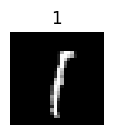

(784,)


1.0

In [3]:
cInCh = 1
cInDim = 28

test_batches = enumerate(mDLTest)

# Load single batch
batch_idx, (listImg, listLabel) = next(test_batches)
print('Image:', listImg.shape, 'Label:', listLabel.shape)
# print(images[0])
strTitle = str(listLabel[0].item())
ShowImg(listImg[0], strTitle, True, cInCh, cInDim, 30)

listImg1D = listImg[0][0].numpy().ravel()
print(listImg1D.shape)

print('Norm=', norm(listImg1D, np.inf))

### Get bounds using hyperrectangle

(784,)
Norm= 1.001
(784,)
Norm= 0.999


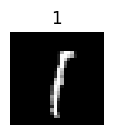

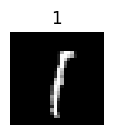

In [7]:
from bound_propagation import BoundModelFactory, HyperRectangle, Parallel, LpNormSet

fEPS = 0.001
objHR = HyperRectangle.from_eps(listImg, fEPS)

upper1D = objHR.upper[0][0].numpy().ravel()
print(upper1D.shape)
print('Norm=', norm(upper1D, np.inf))

lower1D = objHR.lower[0][0].numpy().ravel()
print(lower1D.shape)
print('Norm=', norm(lower1D, np.inf))

ShowImg(objHR.upper[0], strTitle, True, cInCh, cInDim, 30)
ShowImg(objHR.lower[0], strTitle, True, cInCh, cInDim, 30)

### Noise display

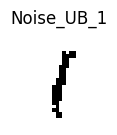

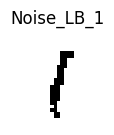

In [8]:
noise_ub = torch.sub(objHR.upper, listImg)
ShowImg(noise_ub[0], 'Noise_UB_'+ strTitle, True, cInCh, cInDim, 30)

noise_lb = torch.sub(listImg, objHR.lower)
ShowImg(noise_lb[0], 'Noise_LB_'+ strTitle, True, cInCh, cInDim, 30)

### Get bounds using Linf norm

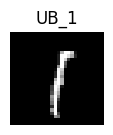

Norm= 1.0


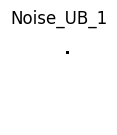

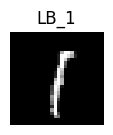

Norm= 0.999


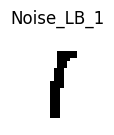

In [11]:
# Bound inputs for Linf
data_max = torch.reshape((1. - mDLTest.mean) / mDLTest.std, (1, -1, 1, 1))
#ShowImg(data_max[0], 'data_max_'+ strTitle, True, cInCh, cInDim, 30)
data_min = torch.reshape((0. - mDLTest.mean) / mDLTest.std, (1, -1, 1, 1))

## Upper Bound
data_ub = torch.min(listImg + (fEPS / mDLTest.std).view(1,-1,1,1), data_max)
ShowImg(data_ub[0], 'UB_'+ strTitle, True, cInCh, cInDim, 30)
print('Norm=', norm(data_ub[0][0].numpy().ravel(), np.inf))

noise_ub = torch.sub(data_ub, listImg)
ShowImg(noise_ub[0], 'Noise_UB_'+ strTitle, True, cInCh, cInDim, 30)

## Lower Bound
data_lb = torch.max(listImg - (fEPS / mDLTest.std).view(1,-1,1,1), data_min)
ShowImg(data_lb[0], 'LB_'+ strTitle, True, cInCh, cInDim, 30)
print('Norm=', norm(data_lb[0][0].numpy().ravel(), np.inf))

noise_lb = torch.sub(data_lb, listImg)
ShowImg(noise_lb[0], 'Noise_LB_'+ strTitle, True, cInCh, cInDim, 30)